Capstone Projet - THe Battle of Neighborhoods



Import required libraries



In [1]:
#import libraries

import pandas as pd
!pip install html5lib 
!pip install lxml

     |████████████████████████████████| 5.5MB 6.5MB/s eta 0:00:01


In [2]:
#install data of Alberta neighborhoods from Wikipedia
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_T')[1]
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
1,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
3,T4A,Airdrie,East Airdrie,51.272450,-113.986980
4,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413


Cleaning the Data


In [3]:
#Only include information for the Borough of Calgary
Calgary_data=df[df.Borough=='Calgary']
Calgary_data.head()

#Remove rows where latitude or longitude is not assigned:
Calgary_data=Calgary_data[Calgary_data.Latitude != 'Not assigned']
Calgary_data=Calgary_data[Calgary_data.Longitude != 'Not assigned']

#Remove the Borough column, as all boroughs are Calgary
Calgary_data.drop(['Borough'], axis=1,inplace=True)


#Check data types, and re-assign if requried
Calgary_data = Calgary_data.astype({"Latitude": float})
Calgary_data = Calgary_data.astype({"Longitude": float})
Calgary_data.dtypes

print ('There are ', Calgary_data.shape[0], "neighborhoods in the dataset")
Calgary_data.head()


There are  34 neighborhoods in the dataset


,Postal Code,Neighborhood,Latitude,Longitude
1,T2A,"Penbrooke Meadows, Marlborough",51.04968,-113.964320
2,T3A,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158
10,T2B,"Forest Lawn, Dover, Erin Woods",51.03180,-113.978600
11,T3B,"Montgomery, Bowness, Silver Springs, Greenwood",51.08090,-114.161600
19,T2C,"Lynnwood Ridge, Ogden, Foothills Industrial, G...",50.98780,-114.000100


Create a map to visualize the neighborhoods

In [4]:
#creat a map of Calgary 
latitude = 51.0447
longitude = -114.0719

import folium

map_calgary = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Calgary_data['Latitude'], Calgary_data['Longitude'], Calgary_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_calgary)  
    
map_calgary

Retrieve Data from Foresquare using the API

In [5]:
import requests
import json

CLIENT_ID = 'MEU2NOJRSIVPRRR234AZC1MWCZ4JEBOHWQLC2KMLR5DL5EM1' 
CLIENT_SECRET = 'H5KICJ2VMGVSBMQCR0MXTLTF4CG1UNSPSMTBXZHTRYP3HR0W'
VERSION = '20180605' 
LIMIT = 100 

#Create function to retrieve Nearby Venues for all neighborhoods in Calgary

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [33]:
#Retrieve venues for Calgary Neighborhoods
Calgary_venues = getNearbyVenues(names=Calgary_data['Neighborhood'],latitudes=Calgary_data['Latitude'],longitudes=Calgary_data['Longitude'])
Calgary_venues


Penbrooke Meadows, Marlborough
Dalhousie, Edgemont, Hamptons, Hidden Valley
Forest Lawn, Dover, Erin Woods
Montgomery, Bowness, Silver Springs, Greenwood
Lynnwood Ridge, Ogden, Foothills Industrial, Great Plains
Rosscarrock, Westgate, Wildwood, Shaganappi, Sunalta
Bridgeland, Greenview, Zoo, YYC
Lakeview, Glendale, Killarney, Glamorgan
Inglewood, Burnsland, Chinatown, East Victoria Park, Saddledome
Hawkwood, Arbour Lake, Citadel, Ranchlands, Royal Oak, Rocky Ridge
Highfield, Burns Industrial
Discovery Ridge, Signal Hill, West Springs, Christie Estates, Patterson, Cougar Ridge
Queensland, Lake Bonavista, Willow Park, Acadia
Martindale, Taradale, Falconridge, Saddle Ridge
Thorncliffe, Tuxedo Park
Sandstone, MacEwan Glen, Beddington, Harvest Hills, Coventry Hills, Panorama Hills
Brentwood, Collingwood, Nose Hill
Tuscany, Scenic Acres
Mount Pleasant, Capitol Hill, Banff Trail
Cranston, Auburn Bay, Mahogany
Kensington, Westmont, Parkdale, University
Northeast Calgary
City Centre, Calgary To

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,Petro-Canada,51.128068,-114.138057,Gas Station
1,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,Edgemont City,51.126473,-114.138997,Asian Restaurant
2,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,Friends Cappuccino Bar & Bake Shop,51.126370,-114.138676,Café
3,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,Mac's,51.128309,-114.137902,Convenience Store
4,"Forest Lawn, Dover, Erin Woods",51.03180,-113.978600,Bonasera Pizza And Sports Bar,51.029893,-113.982543,Bar
...,...,...,...,...,...,...,...
352,"Douglas Glen, McKenzie Lake, Copperfield, East...",50.90230,-113.987300,Forever Good Asian Cuisine,50.903979,-113.989547,Asian Restaurant
353,"Douglas Glen, McKenzie Lake, Copperfield, East...",50.90230,-113.987300,Bus Stop 8436,50.901990,-113.991480,Bus Stop
354,"Douglas Glen, McKenzie Lake, Copperfield, East...",50.90230,-113.987300,McKenna Park,50.900279,-113.990508,Park
355,"Douglas Glen, McKenzie Lake, Copperfield, East...",50.90230,-113.987300,Perogy Boyz Food Truck,50.903736,-113.982378,Food Truck


Clean the Calgary Venue dataset

In [35]:
#Evaluate the types of venues in North East Calgary
Calgary_venues_NE=Calgary_venues[Calgary_venues.Neighborhood=='Northeast Calgary']
Calgary_venues_NE

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
188,Northeast Calgary,51.1494,-114.0019,Pacini,51.150375,-114.000692,American Restaurant
189,Northeast Calgary,51.1494,-114.0019,Acclaim Hotel,51.150384,-114.000140,Hotel


In [36]:
#Evaluate the types of venues in NE Communities 
Calgary_venues_FL=Calgary_venues[Calgary_venues.Neighborhood=='Forest Lawn, Dover, Erin Woods']
Calgary_venues_FL

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
4,"Forest Lawn, Dover, Erin Woods",51.0318,-113.9786,Bonasera Pizza And Sports Bar,51.029893,-113.982543,Bar
5,"Forest Lawn, Dover, Erin Woods",51.0318,-113.9786,7-Eleven,51.029839,-113.982060,Convenience Store
6,"Forest Lawn, Dover, Erin Woods",51.0318,-113.9786,Foggy Gorilla Vaping Co.,51.030038,-113.972642,Smoke Shop


In [75]:
#Evaluate the neighborhoods that contain Vietnamese Restaurants
Calgary_venues_VT=Calgary_venues[Calgary_venues['Venue Category']=='Vietnamese Restaurant']
Calgary_venues_VT

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
23,"Rosscarrock, Westgate, Wildwood, Shaganappi, S...",51.0388,-114.0980,Co Do Vietnamese Restaurant,51.037733,-114.093800,Vietnamese Restaurant
41,"Bridgeland, Greenview, Zoo, YYC",51.0632,-114.0614,Pho Kim Restaurant,51.065873,-114.063895,Vietnamese Restaurant
68,"Lakeview, Glendale, Killarney, Glamorgan",51.0227,-114.1342,Green Cilantro,51.025517,-114.129030,Vietnamese Restaurant
132,"Discovery Ridge, Signal Hill, West Springs, Ch...",51.0566,-114.1815,Treasures of Saigon,51.060721,-114.179830,Vietnamese Restaurant
148,"Thorncliffe, Tuxedo Park",51.0857,-114.0714,Pho Duy Thanh,51.087727,-114.072011,Vietnamese Restaurant
149,"Thorncliffe, Tuxedo Park",51.0857,-114.0714,Rau Bistro,51.087910,-114.072426,Vietnamese Restaurant
169,"Mount Pleasant, Capitol Hill, Banff Trail",51.0696,-114.0862,Pho Phuong VI Noodle House,51.067111,-114.091814,Vietnamese Restaurant
194,"City Centre, Calgary Tower",51.0472,-114.0802,Toa Vietnamese Cuisine,51.047512,-114.076117,Vietnamese Restaurant
291,"Oak Ridge, Haysboro, Kingsland, Kelvin Grove, ...",50.9909,-114.0740,Heart of Saigon,50.993522,-114.070519,Vietnamese Restaurant


In [7]:
#Filter out the Restaurant venues and group by neighborhood
Calgary_restaurant_venues=Calgary_venues[Calgary_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)

Calgary_restaurant_types=Calgary_restaurant_venues.groupby('Venue Category').count()
Calgary_restaurant_types=Calgary_restaurant_types.sort_values('Venue',ascending=False)
Calgary_restaurant_types.head()



,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Restaurant,10,10,10,10,10,10
Vietnamese Restaurant,9,9,9,9,9,9
Italian Restaurant,7,7,7,7,7,7
Sushi Restaurant,7,7,7,7,7,7
Middle Eastern Restaurant,6,6,6,6,6,6


Create visuals on Calgary Restaurants 

#Plot the number of different restaurants around Calgary
import matplotlib.pyplot as plt

bar_graph_data=pd.DataFrame(Calgary_restaurant_types['Venue']).reset_index()
x=bar_graph_data.iloc[:,0]
y=bar_graph_data.iloc[:,1]

plt.figure(figsize=(20,4))
plt.bar(x, y)

#plot labels and titles
plt.xlabel('Restaurant Categories')
plt.xticks(rotation=90)
plt.ylabel('Number of Restaurants in Calgary')
plt.title('Variety of Restaurants in Calgary')


plt.show()

Determine which neighborhoods have the most restaurants


In [9]:
most_venues=Calgary_restaurant_venues.groupby('Neighborhood').count()
most_venues.sort_values('Venue',ascending=False,inplace=True)
most_venues.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Inglewood, Burnsland, Chinatown, East Victoria Park, Saddledome",15,15,15,15,15,15
"Connaught, West Victoria Park",14,14,14,14,14,14
"Oak Ridge, Haysboro, Kingsland, Kelvin Grove, Windsor Park",14,14,14,14,14,14
"Bridgeland, Greenview, Zoo, YYC",12,12,12,12,12,12
"City Centre, Calgary Tower",11,11,11,11,11,11


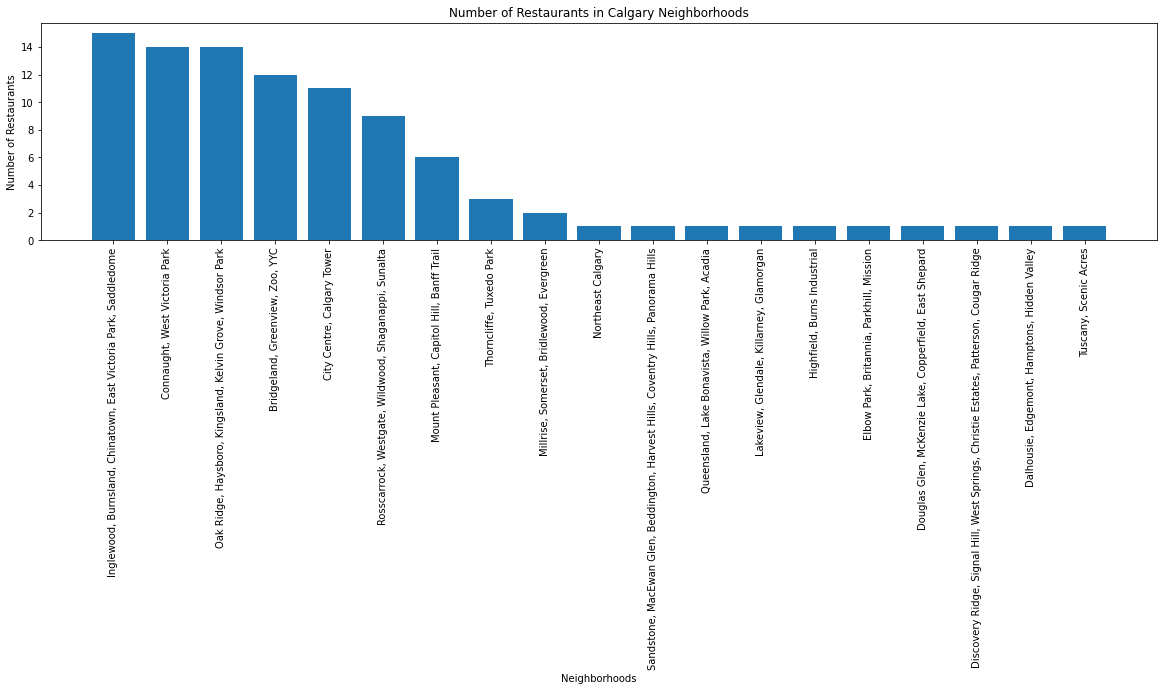

In [10]:
#plot a bar graph to see which neighborhoods have the most restaurants

bar_graph_data=pd.DataFrame(most_venues['Venue']).reset_index()
x=bar_graph_data.iloc[:,0]
y=bar_graph_data.iloc[:,1]

plt.figure(figsize=(20,4))
plt.bar(x, y)

#plot labels and titles
plt.xlabel('Neighborhoods')
plt.xticks(rotation=90)
plt.ylabel('Number of Restaurants')
plt.title('Number of Restaurants in Calgary Neighborhoods')


plt.show()

Analyze each neighborhood to determine the frequency of each type of restaurant


In [11]:
# one hot encoding
Calgary_onehot = pd.get_dummies(Calgary_restaurant_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Calgary_onehot['Neighborhood'] = Calgary_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Calgary_onehot.columns[-1]] + list(Calgary_onehot.columns[:-1])
Calgary_onehot = Calgary_onehot[fixed_columns]

#Group rows by neighborhood and take the mean frequency of each occurrence
Calgary_restaurants_grouped=Calgary_onehot.groupby('Neighborhood').mean().reset_index()
Calgary_restaurants_grouped

,Neighborhood,American Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,...,Moroccan Restaurant,New American Restaurant,Restaurant,Scandinavian Restaurant,Seafood Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,"Bridgeland, Greenview, Zoo, YYC",0.074074,0.000000,0.000000,0.111111,0.000000,0.000000,0.074074,0.000000,0.000000,...,0.074074,0.000000,0.111111,0.00,0.000000,0.111111,0.000000,0.000000,0.000000,0.185185
1,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000
2,"Forest Lawn, Dover, Erin Woods",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333
3,"Inglewood, Burnsland, Chinatown, East Victoria...",0.038462,0.076923,0.076923,0.038462,0.000000,0.000000,0.038462,0.038462,0.076923,...,0.000000,0.038462,0.115385,0.00,0.000000,0.115385,0.038462,0.038462,0.000000,0.038462
4,"Lakeview, Glendale, Killarney, Glamorgan",0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Lynnwood Ridge, Ogden, Foothills Industrial, G...",0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.250000,0.250000,0.000000,0.000000,0.000000,0.250000
6,"Montgomery, Bowness, Silver Springs, Greenwood",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,...,0.000000,0.000000,0.250000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Rosscarrock, Westgate, Wildwood, Shaganappi, S...",0.083333,0.083333,0.000000,0.041667,0.041667,0.041667,0.083333,0.000000,0.000000,...,0.000000,0.083333,0.125000,0.00,0.041667,0.000000,0.000000,0.000000,0.041667,0.041667


In [12]:
#Find the top five most common restaurant types in each neighborhood

num_top_venues = 5

for hood in Calgary_restaurants_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Calgary_restaurants_grouped[Calgary_restaurants_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bridgeland, Greenview, Zoo, YYC----
                      venue  freq
0     Vietnamese Restaurant  0.19
1                Restaurant  0.11
2          Sushi Restaurant  0.11
3  Mediterranean Restaurant  0.11
4        Chinese Restaurant  0.11


----Dalhousie, Edgemont, Hamptons, Hidden Valley----
                       venue  freq
0            Thai Restaurant  0.25
1          Indian Restaurant  0.25
2  Middle Eastern Restaurant  0.25
3           Asian Restaurant  0.25
4        American Restaurant  0.00


----Forest Lawn, Dover, Erin Woods----
                       venue  freq
0   Mediterranean Restaurant  0.33
1          Indian Restaurant  0.33
2      Vietnamese Restaurant  0.33
3         Chinese Restaurant  0.00
4  Middle Eastern Restaurant  0.00


----Inglewood, Burnsland, Chinatown, East Victoria Park, Saddledome----
                      venue  freq
0          Sushi Restaurant  0.12
1                Restaurant  0.12
2  Mediterranean Restaurant  0.08
3      Brazilian Restaurant  0

In [13]:
#Define function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [14]:
#put this information into a dataframe
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Calgary_restaurants_grouped['Neighborhood']

for ind in np.arange(Calgary_restaurants_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Calgary_restaurants_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bridgeland, Greenview, Zoo, YYC",Vietnamese Restaurant,Chinese Restaurant,Sushi Restaurant,Mediterranean Restaurant,Restaurant,Moroccan Restaurant,Fast Food Restaurant,Italian Restaurant,American Restaurant,Japanese Restaurant
1,"Dalhousie, Edgemont, Hamptons, Hidden Valley",Thai Restaurant,Asian Restaurant,Middle Eastern Restaurant,Indian Restaurant,Vietnamese Restaurant,Japanese Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant
2,"Forest Lawn, Dover, Erin Woods",Vietnamese Restaurant,Indian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant
3,"Inglewood, Burnsland, Chinatown, East Victoria...",Sushi Restaurant,Restaurant,Mediterranean Restaurant,Asian Restaurant,Brazilian Restaurant,French Restaurant,Vietnamese Restaurant,Chinese Restaurant,Fast Food Restaurant,Filipino Restaurant
4,"Lakeview, Glendale, Killarney, Glamorgan",Chinese Restaurant,Scandinavian Restaurant,Middle Eastern Restaurant,Italian Restaurant,Vietnamese Restaurant,Japanese Restaurant,Asian Restaurant,Brazilian Restaurant,Dim Sum Restaurant,Falafel Restaurant


Cluster the Neighborhoods


In [15]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

Calgary_clustering = Calgary_restaurants_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Calgary_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 3, 0, 4, 0, 1, 0], dtype=int32)

In [22]:
#Create a new dataframe that includes the cluster
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_).reset_index(drop=True)
neighborhoods_venues_sorted

Calgary_merged = Calgary_data

Calgary_merged = Calgary_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Calgary_merged
Calgary_merged=Calgary_merged.dropna()
Calgary_merged['Cluster Labels'].astype(int)
Calgary_merged


Calgary_merged = Calgary_merged.astype({"Cluster Labels": int})
Calgary_merged.dtypes
Calgary_merged

,Postal Code,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,T3A,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,2,Thai Restaurant,Asian Restaurant,Middle Eastern Restaurant,Indian Restaurant,Vietnamese Restaurant,Japanese Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant
10,T2B,"Forest Lawn, Dover, Erin Woods",51.03180,-113.978600,3,Vietnamese Restaurant,Indian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant
11,T3B,"Montgomery, Bowness, Silver Springs, Greenwood",51.08090,-114.161600,1,Mexican Restaurant,Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Japanese Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant
19,T2C,"Lynnwood Ridge, Ogden, Foothills Industrial, G...",50.98780,-114.000100,0,Vietnamese Restaurant,Asian Restaurant,Sushi Restaurant,Seafood Restaurant,Japanese Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant
20,T3C,"Rosscarrock, Westgate, Wildwood, Shaganappi, S...",51.03880,-114.098000,0,Restaurant,Italian Restaurant,American Restaurant,Asian Restaurant,Fast Food Restaurant,New American Restaurant,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Dim Sum Restaurant
28,T2E,"Bridgeland, Greenview, Zoo, YYC",51.06320,-114.061400,0,Vietnamese Restaurant,Chinese Restaurant,Sushi Restaurant,Mediterranean Restaurant,Restaurant,Moroccan Restaurant,Fast Food Restaurant,Italian Restaurant,American Restaurant,Japanese Restaurant
29,T3E,"Lakeview, Glendale, Killarney, Glamorgan",51.02270,-114.134200,4,Chinese Restaurant,Scandinavian Restaurant,Middle Eastern Restaurant,Italian Restaurant,Vietnamese Restaurant,Japanese Restaurant,Asian Restaurant,Brazilian Restaurant,Dim Sum Restaurant,Falafel Restaurant
37,T2G,"Inglewood, Burnsland, Chinatown, East Victoria...",51.04150,-114.059900,0,Sushi Restaurant,Restaurant,Mediterranean Restaurant,Asian Restaurant,Brazilian Restaurant,French Restaurant,Vietnamese Restaurant,Chinese Restaurant,Fast Food Restaurant,Filipino Restaurant


Separate each cluster to try and determine what attributes define each cluster



In [27]:
#Cluster 0: 
Calgary_merged.loc[Calgary_merged['Cluster Labels'] == 0, Calgary_merged.columns[[1] + list(range(5, Calgary_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,"Lynnwood Ridge, Ogden, Foothills Industrial, G...",Vietnamese Restaurant,Asian Restaurant,Sushi Restaurant,Seafood Restaurant,Japanese Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant
20,"Rosscarrock, Westgate, Wildwood, Shaganappi, S...",Restaurant,Italian Restaurant,American Restaurant,Asian Restaurant,Fast Food Restaurant,New American Restaurant,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Dim Sum Restaurant
28,"Bridgeland, Greenview, Zoo, YYC",Vietnamese Restaurant,Chinese Restaurant,Sushi Restaurant,Mediterranean Restaurant,Restaurant,Moroccan Restaurant,Fast Food Restaurant,Italian Restaurant,American Restaurant,Japanese Restaurant
37,"Inglewood, Burnsland, Chinatown, East Victoria...",Sushi Restaurant,Restaurant,Mediterranean Restaurant,Asian Restaurant,Brazilian Restaurant,French Restaurant,Vietnamese Restaurant,Chinese Restaurant,Fast Food Restaurant,Filipino Restaurant


In [25]:
#Cluster 1: 
Calgary_merged.loc[Calgary_merged['Cluster Labels'] == 1, Calgary_merged.columns[[1] + list(range(5, Calgary_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,"Montgomery, Bowness, Silver Springs, Greenwood",Mexican Restaurant,Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Japanese Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant


In [29]:
#Cluster 2:
Calgary_merged.loc[Calgary_merged['Cluster Labels'] == 2, Calgary_merged.columns[[1] + list(range(5, Calgary_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Dalhousie, Edgemont, Hamptons, Hidden Valley",Thai Restaurant,Asian Restaurant,Middle Eastern Restaurant,Indian Restaurant,Vietnamese Restaurant,Japanese Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant


In [30]:
#Cluster 3:
Calgary_merged.loc[Calgary_merged['Cluster Labels'] == 3, Calgary_merged.columns[[1] + list(range(5, Calgary_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,"Forest Lawn, Dover, Erin Woods",Vietnamese Restaurant,Indian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Falafel Restaurant,Fast Food Restaurant


In [31]:
#Cluster 4:
Calgary_merged.loc[Calgary_merged['Cluster Labels'] == 4, Calgary_merged.columns[[1] + list(range(5, Calgary_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,"Lakeview, Glendale, Killarney, Glamorgan",Chinese Restaurant,Scandinavian Restaurant,Middle Eastern Restaurant,Italian Restaurant,Vietnamese Restaurant,Japanese Restaurant,Asian Restaurant,Brazilian Restaurant,Dim Sum Restaurant,Falafel Restaurant


In [23]:
#Visualize the clusters

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
import matplotlib.cm as cm
import matplotlib.colors as colors

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Calgary_merged['Latitude'], Calgary_merged['Longitude'], Calgary_merged['Neighborhood'], Calgary_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Install Calgary Census Data to learn about the resident population

In [32]:
#install Calgary neighborhood demographics 
df2 = pd.read_html('https://great-news.ca/demographics/')
df2=pd.DataFrame(df2[0])
df2

,Community,Newsletter Name,Median Household Income,Median Age,Population 2014,Dwellings 2014,City Quadrant,Median Home Sale Price
0,Abbeydale,-,"$55,345",34,6071,2031,SE,"$305,000"
1,Acadia,Acadia,"$46,089",42,10969,5067,SE,"$447,000"
2,Albert Park / Radisson Heights,-,"$38,019",37,6529,2936,SE,"$349,900"
3,Altadore,The Source,"$53,786",37,9518,4537,SW,"$925,000"
4,Applewood Park,-,"$65,724",33,6864,2228,SE,"$380,000"
...,...,...,...,...,...,...,...,...
175,Willow Park,Your Willow Park Maple Ridge,"$63,588",45,5440,2284,SE,"$705,000"
176,Windsor Park,The Elbow Scene,"$39,425",37,4417,2453,SW,"$675,000"
177,Winston Heights/Mountview,Community Matters,"$41,065",42,3845,1899,NE,"$625,000"
178,Woodbine,Your Woodcreek Chronicle,"$83,844",42,9162,3371,SW,"$460,000"


Clean the Census data

In [66]:
#Group by city quadrants

df2.groupby('City Quadrant')
Calgary_income=df2


#Calgary_income['Median Household Income']=Calgary_income['Median Household Income'].str.replace('$', '')
#Calgary_income['Median Household Income']=Calgary_income['Median Household Income'].str.replace(',', '')


Calgary_income['Median Household Income']=Calgary_income['Median Household Income'].astype(str).astype(int)
Calgary_income.dtypes
Calgary_income_grouped=Calgary_income.groupby('City Quadrant').mean()
Calgary_income_grouped.reset_index(inplace=True)
Calgary_income_grouped

,City Quadrant,Median Household Income,Median Age,Population 2014,Dwellings 2014
0,NE,56608.250000,35.850000,9006.500000,3211.200000
1,NW,66574.647059,38.627451,7075.254902,2734.215686
2,SE,66750.771429,37.885714,7009.514286,2724.314286
3,SW,75388.391892,40.540541,5059.202703,2207.405405


Visualize the Census Data

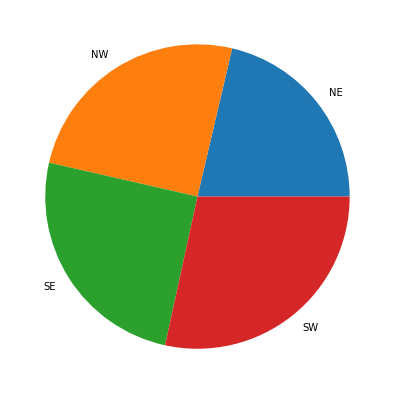

In [68]:
#Create a pie chart to display Median Household Income among city quadrants

labels=['NE', 'NW','SE','SW']
data=Calgary_income_grouped['Median Household Income']

fig=plt.figure(figsize=(10,7))
plt.pie(data,labels=labels)
plt.show()

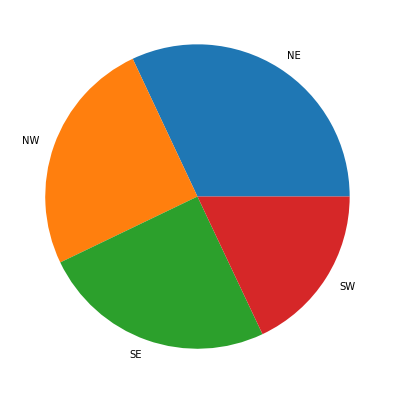

In [69]:
#Create pie chart to display the Population among city quadrants 
labels=['NE', 'NW','SE','SW']
data=Calgary_income_grouped['Population 2014']

fig=plt.figure(figsize=(10,7))
plt.pie(data,labels=labels)
plt.show()

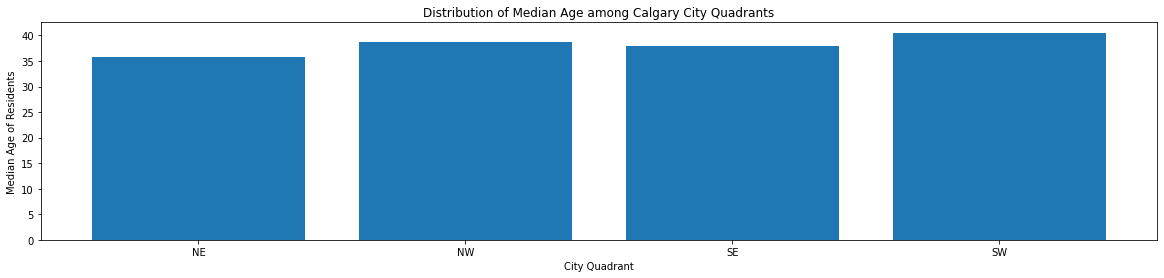

In [73]:
#Create a bar chart to dispaly the distribution of Median Age among city quadrants

x=Calgary_income_grouped['City Quadrant']
y=Calgary_income_grouped['Median Age']

plt.figure(figsize=(20,4))
plt.bar(x, y)

#plot labels and titles
plt.xlabel('City Quadrant')
plt.ylabel('Median Age of Residents')
plt.title('Distribution of Median Age among Calgary City Quadrants')


plt.show()

In [79]:
#Find neighborhoods in NE Calgary 
df2=df2[df2['City Quadrant']=='NE']
df2


,Community,Newsletter Name,Median Household Income,Median Age,Population 2014,Dwellings 2014,City Quadrant,Median Home Sale Price
18,Bridgeland/Riverside,Bridgeland-Riverside Bridges,44363,42,11924,6752,NE,"$612,500"
24,Castleridge,-,57923,33,6396,1983,NE,"$408,000"
37,Coral Springs,-,83067,37,6018,1542,NE,"$470,000"
43,Crescent Heights,The Crescent Heights View,43123,37,6235,3615,NE,"$560,000"
62,Falconridge,-,48512,32,10840,3375,NE,"$315,000"
70,Harvest Hills,-,78949,38,7594,2573,NE,"$441,000"
91,Marlborough,-,53921,40,8989,3177,NE,"$355,000"
92,Marlborough Park,-,52535,37,8741,3095,NE,"$362,000"
93,Martindale,-,65185,32,14761,4062,NE,"$348,500"
95,Mayland Heights,Crossroads Convenor,49581,39,6357,2818,NE,"$445,000"
